In [1]:
from Game import *

Version:  0.3.07


In [2]:
from tqdm import tqdm

In [3]:
def initial_state():
    return 9

def valid_moves(state,player):
    if state==1:
        return [1]
    elif state==2:
        return [1,2]
    else:
        return [1,2,3]
        
def show_state(state):
    print ("There are ",state," sticks left.")

def update_state(state,player,move):
    new_state=state-move
    return new_state

def win_status(state,player):

    if state==1:
        return 'win'
    
    elif state==0:
        return 'lose'
    
    else:
        return None


In [4]:
def random_move(state,player):

    moves=valid_moves(state,player)
    return random.choice(moves)

def human_move(state,player):
    print("Player ", player, end=' ')
    valid_move=False
    while not valid_move:
        move=eval(input('What is your move? '))

        if move in valid_moves(state,player):
            valid_move=True
        else:
            print("Illegal move.")

    return move
 

In [5]:


random_agent=Agent(random_move)
human_agent=Agent(human_move)


In [6]:
from Game.mcts import *
def mcts_move(state,player,info):
    T=info.T
    values,moves=mcts_values(state,player,T,info.seconds)
    return top_choice(moves,values)

mcts_agent=Agent(mcts_move)
mcts_agent.T=Table()
mcts_agent.seconds=1

**looks like one mcts game needs to be run for the mcts_run_simulation to have copies of the games functions -- this is a bug**

In [7]:
g=Game(number_of_games=1)
g.display=False
wins=g.run(mcts_agent,random_agent)
g.report()

Total number of games:  1
Player 1 (mcts) Winning 100.00 percent
Player 2 (random) Winning 0.00 percent
Tie 0.00 percent


In [8]:
state=initial_state()
T=Table()
mcts_run_simulation(state,player=1,T=T,save_states=True)

((9, 6, 3), (1, 2, 1), 1)

In [9]:
import numpy as np
from nn import NumpyNetTable

Version  1.0.7
nn 0 0 2


In [10]:
def all_possible_moves():
    all_moves=[1,2,3]
            
    return all_moves

# length 9 with +1, -1, 0
def state_to_X(state):
    max_state=9
    import numpy as np
    arr=np.zeros((1,max_state))  # number of samples, size
    arr[0,state-1]=1
                     
    return arr



In [11]:
state=8
state

8

In [12]:
state_to_X(state)

array([[0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [13]:
from datetime import datetime

In [14]:
def QNN_move(state,player,info):
    Q=info.Q
    last_action=info.last_action
    last_state=info.last_state

    learning=info.learning
    alpha=info.alpha  # learning rate
    gamma=info.gamma  # memory 
    epsilon=info.epsilon  # probability of doing random move
    number_of_games_mcts=info.number_of_games_mcts  # for the MCTS
    T=info.T  # mcts table
    if T is None:  #if the table is None, then reset it each move for memory
        T=Table()
    
    new_state=state
    new_actual_moves=valid_moves(new_state,player)    
    new_action_values=Q[new_state]
    new_values=[new_action_values[move] for move in new_actual_moves] 
    
    if learning and random.random()<epsilon:  # random move
        action=random.choice(new_actual_moves)
    else:
        action=top_choice(new_actual_moves,weights=new_values)

            
#         # Ask the model for the Q values of the old state (inference)
#         old_state_Q_values = self.get_Q(old_state)

#         # Ask the model for the Q values of the new state (inference)
#         new_state_Q_values = self.get_Q(new_state)

#         # Real Q value for the action we took. This is what we will train towards.
#         old_state_Q_values[action] = reward + self.discount * np.amax(new_state_Q_values)
        
    if not learning or alpha==0:  # no learning
        return action

    # we won't learn from the current game, we'll play out a number of MCTS games
    calculation_time=1 # maximum seconds of mcts
    games=0
    begin=datetime.utcnow()
    all_states=[]
    while ( (datetime.utcnow()-begin).total_seconds()< calculation_time) and (games<number_of_games_mcts):
        states,moves,game_reward=mcts_run_simulation(state,player,max_moves=30,T=T,save_states=True)
        all_states.append((states,moves,game_reward))
        games+=1

    for states,moves,game_reward in all_states:

        possible_moves=Q.all_moves
        for k in range(len(states)-1):
            state1=states[k]
            move1=moves[k]
            state2=states[k+1]

            actual_moves1=valid_moves(state1,player)
            action_values1=Q[state1]
            values1=[action_values1[move] for move in actual_moves1] 

            actual_moves2=valid_moves(state2,player)
            action_values2=Q[state2]
            values2=[action_values2[move] for move in actual_moves2] 

            target=[]
            for i,move in enumerate(possible_moves):
                if move==move1:
                    target.append(0 + gamma*max(values2))  # max of actually available values, mid-game reward
                elif move in actual_moves1:  # keep the old values for valid moves
                    target.append(action_values1[move])
                else:
                    target.append(-1)  # lose with illegal move
    
            Q[state1]=target            

        # last move
        state2=states[-1]
        move2=moves[-1]
        actual_moves2=valid_moves(state2,player)
        action_values2=Q[state2]
        values2=[action_values2[move] for move in actual_moves2] 

        r=game_reward
        
        target=[]
        for i,move in enumerate(possible_moves):
            if move==move2:
                target.append(r)  # max of actually available values
            elif move in actual_moves2:  # keep the old values for valid moves
                target.append(action_values2[move])
            else:
                target.append(-1)  # lose with illegal move

        Q[state2]=target            
    
        
    return action



In [27]:
QNN1_agent=Agent(QNN_move)

QNN1_agent.alpha=0.05  # learning rate
QNN1_agent.gamma=0.95  # memory
QNN1_agent.epsilon=0.1  # chance of making a random move
QNN1_agent.T=Table()  # this is for MCTS
QNN1_agent.number_of_games_mcts=25
QNN1_agent.learning=True


QNN2_agent=Agent(QNN_move)

QNN2_agent.alpha=0.05  # learning rate
QNN2_agent.gamma=0.95  # memory
QNN2_agent.epsilon=0.1  # chance of making a random move
QNN2_agent.T=Table()  # this is for MCTS
QNN2_agent.number_of_games_mcts=25
QNN2_agent.learning=True


In [28]:
state=initial_state()
initial_X=state_to_X(state)
all_moves=all_possible_moves()

print(state)
print(initial_X)

QNN1_agent.Q=NumpyNetTable(state_to_X,all_possible_moves(),
                {
                    'input':initial_X.shape[1],               # number of inputs
                    'hidden':[(10,'relu'),],
                    'output':(len(all_moves),'linear'),  # number of moves
                    'cost':'mse',
                },
                        verbose=False)

QNN2_agent.Q=NumpyNetTable(state_to_X,all_possible_moves(),
                {
                    'input':initial_X.shape[1],               # number of inputs
                    'hidden':[(10,'relu'),],
                    'output':(len(all_moves),'linear'),  # number of moves
                    'cost':'mse',
                },
                        verbose=False)

# initialize things
QNN1_agent.Q[state]=[0]*len(all_possible_moves())
QNN2_agent.Q[state]=[0]*len(all_possible_moves())


9
[[0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [29]:
from Game.minimax import *
def minimax_move(state,player):
    values,moves=minimax_values(state,player,display=False)
    return top_choice(moves,values)


minimax_agent=Agent(minimax_move)

In [30]:
agent1=QNN1_agent
agent2=QNN2_agent

N_test=100
N_train=5

In [31]:
S1=Storage()
S2=Storage()

one1,two1,ties1,illegal1,N1,total_train1=0,0,0,0,0,0
one2,two2,ties2,illegal2,N2,total_train2=0,0,0,0,0,0

In [32]:
for i in tqdm(range(100)):
    agent1.learning=True
    agent2.learning=True
    g=Game(number_of_games=N_train)
    g.display=False
    result1=g.run(agent1,agent2)

    
    agent1.learning=False
    agent2.learning=False
    g=Game(number_of_games=N_test)
    g.display=False
    result=g.run(agent1,random_agent)
    one1,two1,ties1,illegal1,N1,total_train1=(one1+result.count(1),
                                two1+result.count(2),
                                ties1+result.count(0),
                                illegal1+result.count(3),
                                N1+len(result),
                                total_train1+N_train)
    
    S1+=one1/N1*100,two1/N1*100,ties1/N1*100,illegal1/N1*100,N1,total_train1

    agent1.learning=False
    agent2.learning=False
    g=Game(number_of_games=N_test)
    g.display=False
    result=g.run(random_agent,agent2)
    one2,two2,ties2,illegal2,N2,total_train2=(one2+result.count(1),
                                two2+result.count(2),
                                ties2+result.count(0),
                                illegal2+result.count(3),
                                N2+len(result),
                                total_train2+N_train)
    
    S2+=one2/N2*100,two2/N2*100,ties2/N2*100,illegal2/N2*100,N2,total_train2



100%|█████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


In [21]:
%matplotlib inline
from matplotlib.pyplot import figure,plot,grid,legend,xlabel,ylabel,title

Text(0, 0.5, 'Percent')

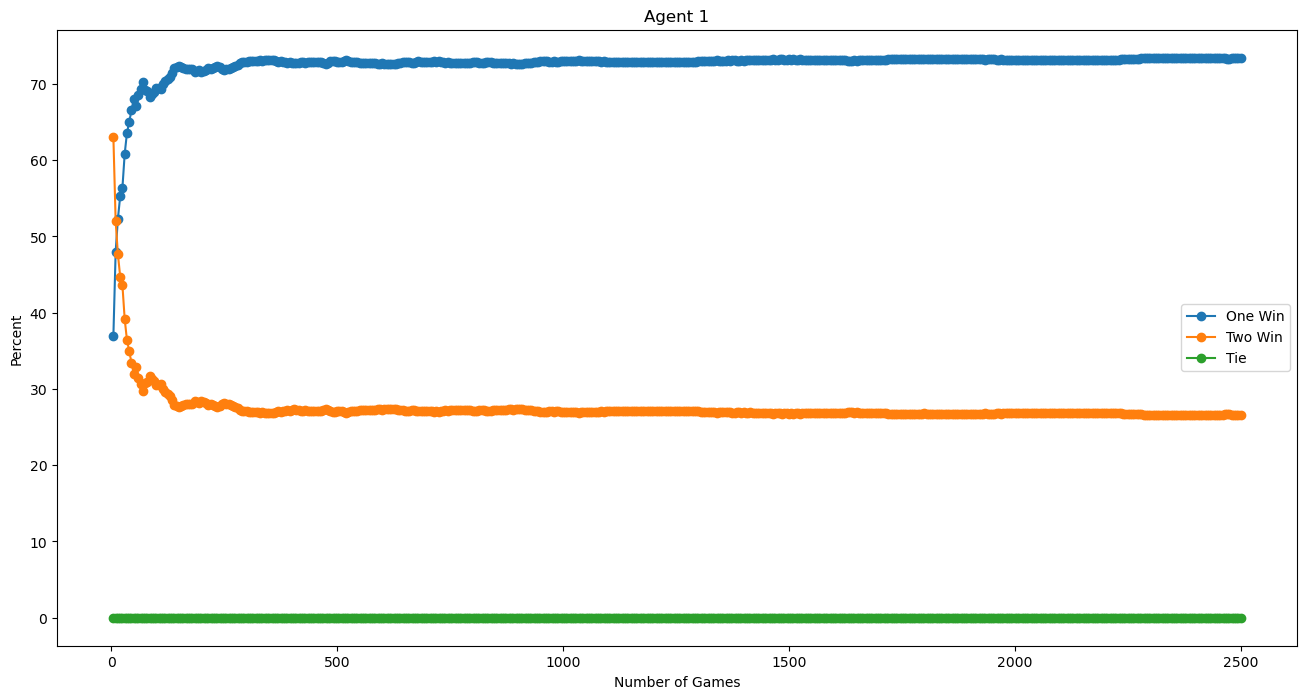

In [22]:
y1,y2,y0,y3,x,t=S1.arrays()
figure(figsize=(16,8))
plot(t,y1,'-o',label='One Win')
plot(t,y2,'-o',label='Two Win')
plot(t,y0,'-o',label='Tie')
if any(y3):
    plot(t,y3,'-o',label='Illegal')
legend()
title('Agent 1')
xlabel('Number of Games')
ylabel('Percent')

Text(0, 0.5, 'Percent')

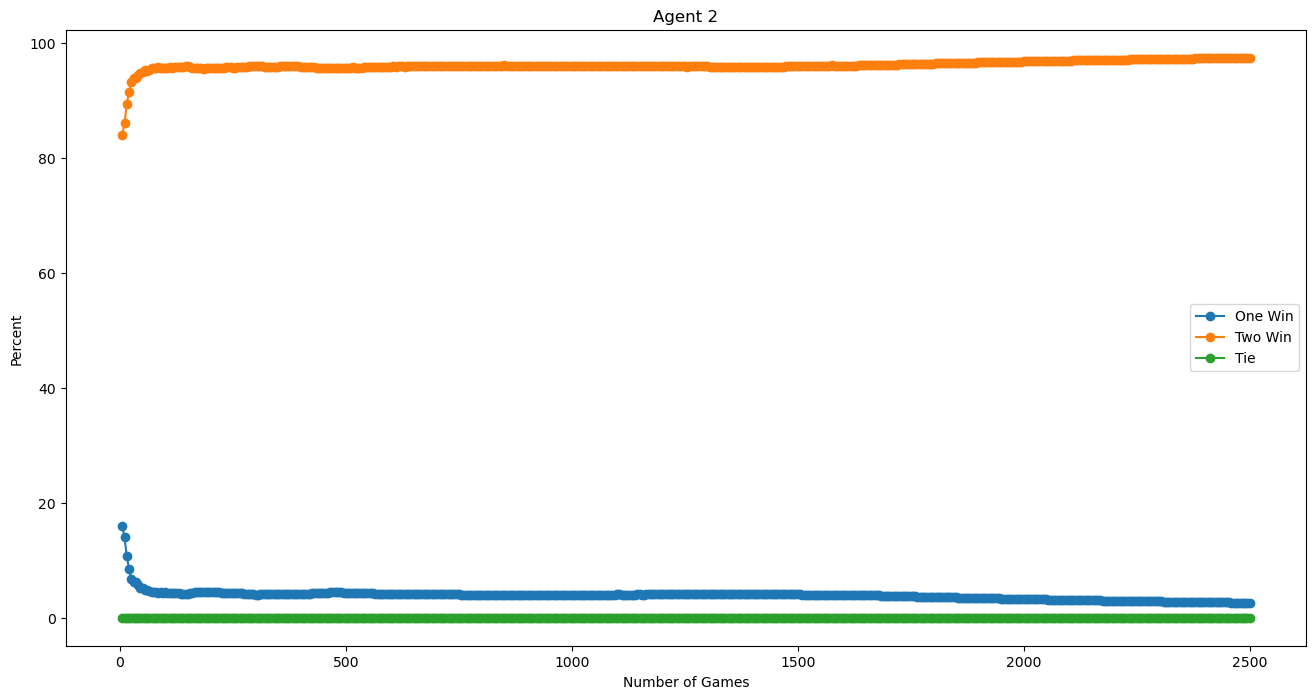

In [23]:
y1,y2,y0,y3,x,t=S2.arrays()
figure(figsize=(16,8))
plot(t,y1,'-o',label='One Win')
plot(t,y2,'-o',label='Two Win')
plot(t,y0,'-o',label='Tie')
if any(y3):
    plot(t,y3,'-o',label='Illegal')
legend()
title('Agent 2')
xlabel('Number of Games')
ylabel('Percent')

In [24]:
agent1.learning=False
agent2.learning=False
g=Game(number_of_games=100)
g.display=False
result=g.run(agent1,random_agent)
g.report()


Total number of games:  100
Winning 81.00 percent
Losing 19.00 percent
Tie 0.00 percent


In [25]:
agent1.learning=False
agent2.learning=False
g=Game(number_of_games=100)
g.display=False
result=g.run(random_agent,agent2)
g.report()


Total number of games:  100
Winning 0.00 percent
Losing 100.00 percent
Tie 0.00 percent


In [26]:
agent1.learning=False
agent2.learning=False
g=Game(number_of_games=100)
g.display=False
result=g.run(minimax_agent,agent2)
g.report()


Total number of games:  100
Winning 0.00 percent
Losing 100.00 percent
Tie 0.00 percent


In [27]:
for state in range(1,9+1):
    print(state,":",QNN2_agent.Q[state])

1 : {1: -0.5977151796684406, 2: 0.6192764046633454, 3: -0.7863542530645178}
2 : {1: 0.9995570657433875, 2: -0.6802303856804999, 3: -0.9995733819065915}
3 : {1: -1.02063458745531, 2: 0.9998308382941161, 3: -0.973683451707656}
4 : {1: -0.2602530315814467, 2: -0.012796834156471924, 3: 1.0000037744231665}
5 : {1: -1.0561012187922194, 2: -1.02478777240677, 3: -0.9965322234546419}
6 : {1: 0.9506073459151209, 2: -0.2296899272186467, 3: -0.12947075519087817}
7 : {1: -0.5589168566397177, 2: 0.9378678526701518, 3: 0.2697524104823829}
8 : {1: -0.0795837818590783, 2: 0.6784521857376866, 3: 0.9482274730515221}
9 : {1: -0.751160618234101, 2: 0.04806960339237503, 3: -0.4245506033101528}
